In [1]:
# PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


In [2]:
# RAW HISTORIC INFORMATION:
#    Source 0: Datetime basic information unit
#    Source 1: Calendar variables
#    Source 2: CENACE Electricity load by gerencia
#    Source 3: APIXU Weather for 3 main cities
#    Source X: Time Series Features

#    Source 4: LMPs CENACE
#    Source 5: Quandl input prices


In [3]:
######################################
# SOURCE 0: DATE TIME KEY
######################################

# Datetime and date
datetime_list = [dt.datetime(2000, 1, 1) + dt.timedelta(hours=h) for h in range(150336)] #150325
source0_datetime = pd.DataFrame(datetime_list, columns=['date_time'])
source0_datetime['date'] = source0_datetime['date_time'].dt.floor('d')

# Day of the week
source0_datetime['s0.monday'] = (source0_datetime['date'].dt.weekday == 0)*1
source0_datetime['s0.sunday'] = (source0_datetime['date'].dt.weekday == 6)*1
source0_datetime['s0.saturday'] = (source0_datetime['date'].dt.weekday == 5)*1

source0_datetime.dtypes


date_time      datetime64[ns]
date           datetime64[ns]
s0.monday               int64
s0.sunday               int64
s0.saturday             int64
dtype: object

In [4]:
######################################
# SOURCE 1: CALENDAR DATE VARIABLES
######################################

# Holidays
feriados = pd.read_csv('./data/historic_data/Dias_Festivos.csv', sep=',')

# Non monday
feriados_nolunes = []
for index, row in feriados.query('holiday_class != "lunes antes"').iterrows():
    for year in range(2000, 2018):
        feriados_nolunes.append(dt.date(year, row['month'], row['day']))

# Last Monday (Vicente Fox)
feriados_lunes = []
for index, row in feriados.query('holiday_class == "lunes antes"').iterrows():
    for year in range(2000, 2018):
        date = dt.date(year, row['month'], row['day'])
        last_monday = date - dt.timedelta(days=date.weekday())
        feriados_lunes.append(last_monday)

# Semanas Santas, hardcoded
semana_santa2010 = [dt.date(2010,3,28)+dt.timedelta(day) 
                    for day in range(int((dt.date(2010,4,4) - dt.date(2010,3,28)).days))]
semana_santa2011 = [dt.date(2011,4,17)+dt.timedelta(day) 
                    for day in range(int((dt.date(2011,4,24) - dt.date(2011,4,17)).days))]
semana_santa2012 = [dt.date(2012,4,1)+dt.timedelta(day) 
                    for day in range(int((dt.date(2012,4,8) - dt.date(2012,4,1)).days))]
semana_santa2013 = [dt.date(2013,3,24)+dt.timedelta(day) 
                    for day in range(int((dt.date(2013,3,31) - dt.date(2013,3,24)).days))]
semana_santa2014 = [dt.date(2014,4,13)+dt.timedelta(day) 
                    for day in range(int((dt.date(2014,4,20) - dt.date(2014,4,13)).days))]
semana_santa2015 = [dt.date(2015,3,29)+dt.timedelta(day) 
                    for day in range(int((dt.date(2015,4,5) - dt.date(2015,3,29)).days))]
semana_santa2016 = [dt.date(2016,3,20)+dt.timedelta(day) 
                    for day in range(int((dt.date(2016,3,27) - dt.date(2016,3,20)).days))]

semanas_santas = semana_santa2010+semana_santa2011+semana_santa2012+semana_santa2013 \
                 +semana_santa2014+semana_santa2015+semana_santa2016

# Bind
feriados = semanas_santas + feriados_lunes + feriados_nolunes
source1_feriados = pd.DataFrame(feriados, columns=['date'])

source1_feriados.dtypes


date    object
dtype: object

In [5]:
######################################
# SOURCE 2: DEMAND BY GERENCIA
######################################
source2_load = pd.read_csv('./data/historic_data/Demanda_2000_2017.csv', sep=',')
source2_load['date_time'] = pd.to_datetime(source2_load['date_time'])

# Filter gerencias in SIN
# source2_load = source2_load[['fecha2', 'CEL','ORI','OCC','NOR','NTE','NES','PEN']]

# Rename and drop
new_names = {"CEL": "s2.CEL", 
             "ORI": "s2.ORI", 
             "OCC": "s2.OCC", 
             "NOR": "s2.NOR",
             "NTE": "s2.NTE", 
             "NES": "s2.NES", 
             "PEN": "s2.PEN",
             "BCN": "s2.BCN",
             "BCS": "s2.BCS",
             "SIN": "s2.SIN",
             "SEN": "s2.SEN"}
source2_load = source2_load.rename(index=str, columns=new_names)

source2_load.dtypes


date_time    datetime64[ns]
s2.CEL              float64
s2.ORI              float64
s2.OCC              float64
s2.NOR              float64
s2.NTE              float64
s2.NES              float64
s2.BCN              float64
s2.PEN              float64
s2.BCS              float64
s2.SIN              float64
s2.SEN              float64
dtype: object

In [6]:
######################################
# SOURCE 3: APIXU WEATHER
######################################
source3_cities = pd.read_csv('./data/historic_data/Ciudades.csv', sep=',')
source3_cities = source3_cities[ (source3_cities['id2'] <= 3) ]

source3_weather = pd.read_csv('./data/historic_data/Weather.csv', sep=',')
source3_weather['date_time'] = pd.to_datetime(source3_weather['date_time'])
source3_weather['date_time'] = source3_weather['date_time'].dt.round('60min')

# Rename and drop
new_names = {"gerencia": "s3.gerencia",
             "heatindex_c_1": "s3.heatindex_c_1", 
             "heatindex_c_2": "s3.heatindex_c_2", 
             "heatindex_c_3": "s3.heatindex_c_3", 
             "humidity_1": "s3.humidity_1",
             "humidity_2": "s3.humidity_2", 
             "humidity_3": "s3.humidity_3", 
             "temp_c_1": "s3.temp_c_1", 
             "temp_c_2": "s3.temp_c_2",
             "temp_c_3": "s3.temp_c_3"}

source3_weather = source3_weather.rename(index=str, columns=new_names)
source3_weather = source3_weather.drop(["name_1", "name_2", "name_3"], axis=1)

source3_weather.dtypes


s3.gerencia                 object
date_time           datetime64[ns]
s3.heatindex_c_1           float64
s3.heatindex_c_2           float64
s3.heatindex_c_3           float64
s3.humidity_1              float64
s3.humidity_2              float64
s3.humidity_3              float64
s3.temp_c_1                float64
s3.temp_c_2                float64
s3.temp_c_3                float64
dtype: object

In [7]:
######################################
# FILTERS [0,1,2,3]
######################################

# Source 2
source2_load = source2_load[['date_time', 's2.NES']]

# Source 3
source3_weather = source3_weather[source3_weather['s3.gerencia']=='NES']

######################################
# MERGE SOURCE[0,1,2,3]
######################################
# Implicit full outer joins

# Source 0
base = source0_datetime.copy()

# Source 1
base['s1.holiday'] = base['date'].isin(source1_feriados['date'])*1

# Source 2
base = pd.merge_ordered(base, source2_load, on = ['date_time'])

# Source 3
base = pd.merge_ordered(base, source3_weather, on = ['date_time'])


In [8]:
######################################
# CHECK MERGE SOURCE[0,1,2, 3]
######################################
print("source0_datetime.shape:", source0_datetime.shape)
print("source1_feriados.shape:", source1_feriados.shape)
print("source2_load.shape:", source2_load.shape)
print("source3_weather.shape:", source3_weather.shape)

# check dimensions of each source
print("base.shape", base.shape)
base.dtypes


source0_datetime.shape: (150336, 5)
source1_feriados.shape: (391, 1)
source2_load.shape: (150336, 2)
source3_weather.shape: (66082, 11)
base.shape (153816, 17)


date_time           datetime64[ns]
date                datetime64[ns]
s0.monday                  float64
s0.sunday                  float64
s0.saturday                float64
s1.holiday                 float64
s2.NES                     float64
s3.gerencia                 object
s3.heatindex_c_1           float64
s3.heatindex_c_2           float64
s3.heatindex_c_3           float64
s3.humidity_1              float64
s3.humidity_2              float64
s3.humidity_3              float64
s3.temp_c_1                float64
s3.temp_c_2                float64
s3.temp_c_3                float64
dtype: object

In [9]:
######################################
# SOURCE X: TIME SERIES FEATURES
######################################
base['sX.y'] = base['s2.NES']
base['sX.ones'] = 1

base.sort_values( by = ['date_time'], ascending = True)
base['sX.lag24_y'] = base['sX.y'].shift(24)
base['sX.lag168_y'] = base['sX.y'].shift(168)

base['sX.temp_c_1'] = base['s3.temp_c_1']
base['sX.temp_c_2'] = base['s3.temp_c_2']
base['sX.temp_c_3'] = base['s3.temp_c_3']


In [10]:
######################################
# DATA QUALITY
######################################
# Source 0: Datetime basic information unit
print(base.filter(regex='s0', axis=1).isna().sum())

# Source 1: Calendar variables
print(base.filter(regex='s1', axis=1).isna().sum())

# Source 2: CENACE Electricity load by gerencia
print(base.filter(regex='s2', axis=1).isna().sum())

# Source 3: APIXU Weather for 3 main cities
print(base.filter(regex='s3', axis=1).isna().sum())

# Source X: Time Series Features
print(base.filter(regex='sX', axis=1).isna().sum())
base['sX.lag168_y'] = base['sX.lag168_y'].fillna(pd.DataFrame.mean(base['sX.lag168_y']))
base['sX.lag24_y'] = base['sX.lag24_y'].fillna(pd.DataFrame.mean(base['sX.lag24_y']))

######################################
# DATA CLEANING
######################################
base = base[base['s3.temp_c_1'].notna()]
base = base[base['sX.y'].notna()]
print("base.shape", base.shape)


######################################
# OUTLIER CLEANING
######################################


s0.monday      3480
s0.sunday      3480
s0.saturday    3480
dtype: int64
s1.holiday    3480
dtype: int64
s2.NES    3480
dtype: int64
s3.gerencia          87734
s3.heatindex_c_1    114595
s3.heatindex_c_2    122295
s3.heatindex_c_3    114595
s3.humidity_1       114595
s3.humidity_2       122295
s3.humidity_3       114595
s3.temp_c_1          87734
s3.temp_c_2          87734
s3.temp_c_3          87734
dtype: int64
sX.y            3480
sX.ones            0
sX.lag24_y      3480
sX.lag168_y     3480
sX.temp_c_1    87734
sX.temp_c_2    87734
sX.temp_c_3    87734
dtype: int64
base.shape (62602, 24)


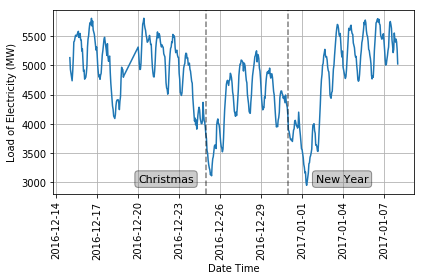

In [11]:
# PLOT DEMAND CHRISTMAS-NEW YEAR
def plot_load_holidays(data, start_date, end_date, output_path=None):
    filter_plot = (data['date_time']>=start_date) & (data['date_time']<=end_date)
    data_plot = data[filter_plot]
    plt.plot(data_plot['date_time'], data_plot['s2.NES'])
    plt.ylabel('Load of Electricity (MW)')
    plt.xlabel('Date Time')
    plt.xticks(rotation=90)
    
    # Holidays
    props = dict(boxstyle='round', facecolor='gray', alpha=0.4)
    plt.axvline(x=dt.datetime(2016,12,25), color='black', linestyle='--', alpha=0.5)
    plt.text(dt.datetime(2016,12,20), 3000, 'Christmas', fontsize=11, bbox=props)
    plt.axvline(x=dt.datetime(2016,12,31), color='black', linestyle='--', alpha=0.5)
    plt.text(dt.datetime(2017, 1, 2), 3000, 'New Year', fontsize=11, bbox=props)
    plt.tight_layout()
    plt.grid()
    if output_path is not None:
        plt.savefig(output_path, pad_inches=0.1)
    plt.show()
    
start_date = dt.datetime(2016,12,15)
end_date = dt.datetime(2017,1,8)
plot_load_holidays(base, start_date, end_date, output_path='./outputs/load_gerencia.png')


In [12]:
# PLOT DEMAND CHRISTMAS-NEW YEAR
def plot_load_prediction(data, data_pred, start_date, end_date, model_name, output_path=None):
    assert data.shape[0]==data_pred.shape[0]
    filter_plot = (data['date_time']>=start_date) & (data['date_time']<=end_date)
    data_plot = data[filter_plot]
    data_pred_plot = data_pred[filter_plot]
    plt.plot(data_plot['date_time'], data_plot['s2.NES'], label='Original')
    plt.plot(data_plot['date_time'], data_pred_plot['ypred'], linestyle='--', label=model_name)
    plt.ylabel('Load of Electricity (MW)')
    plt.xlabel('Date Time')
    plt.xticks(rotation=90)
    plt.axvline(x=dt.datetime(2016,12,25), color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=dt.datetime(2016,12,31), color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.grid()
    plt.legend()
    if output_path is not None:
        plt.savefig(output_path, pad_inches=0.1)
    plt.show()


In [13]:
######################################
# TIME SERIES MODELS 1: SIMILAR DAYS
######################################

class SimilarDays(object):
    def __init__(self, base, parameters):
        self.base = base
    
    def fit(self):
        self.base['s0.mon_sat_sun'] = 0
        self.base.loc[(self.base['s0.monday'] == 1) |
                             (self.base['s0.sunday'] == 1) | 
                             (self.base['s0.saturday'] == 1), 's7.mon_sat_sun'] = 1
    
    def predict(self):
        Ypred = pd.DataFrame(self.base['date_time'].copy())
        Ypred['ypred'] = 0
        Ypred.loc[self.base['s0.mon_sat_sun']==1, 'ypred'] = self.base.loc[ \
                                            self.base['s0.mon_sat_sun']==1,'sX.lag168_y']
        Ypred.loc[self.base['s0.mon_sat_sun']!=1, 'ypred'] = self.base.loc[ \
                                            self.base['s0.mon_sat_sun']!=1,'sX.lag168_y']
        return Ypred


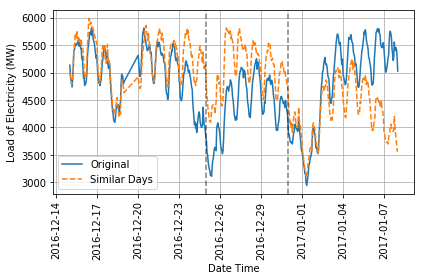

In [14]:
# Declare, fit, predict
model1 = SimilarDays(base, parameters={})
model1.fit()
ypred1 = model1.predict()

start_date = dt.datetime(2016,12,15)
end_date = dt.datetime(2017,1,8)
plot_load_prediction(base, ypred1, start_date, end_date, 'Similar Days', 
                     output_path='./outputs/model1_similares.png')


In [15]:
######################################
# TIME SERIES MODELS 2: MOVING AVERAGE
######################################

# # model2 = ExponentialSmoothing(np.asarray(base['s7.y']), seasonal_periods=7, trend='add', seasonal='add')
# model2 = SimpleExpSmoothing(np.asarray(base['s7.y']))
# model2 = model2.fit(smoothing_level = 0.3) #smoothing_level, smoothing_slope, smoothing_seasonal, damping_slope

# ypred = model2.predict(start=0, end=base.shape[0])

# ypred2 = pd.DataFrame(base['date_time'].copy())
# ypred2['ypred'] = ypred[:-1]
# mse_model2 = mean_squared_error(base['s7.y'], ypred2['ypred'])

# plot_load_prediction(base, ypred2, start_date, end_date, 'Moving Average', 
#                      output_path='./outputs/model2_HoltWinter.png')


In [16]:
######################################
# TIME SERIES MODELS 3: AR
######################################

class AR(object):
    def __init__(self, base, **kwargs):
        self.base = base
        self.model = LinearRegression(**kwargs)
        variables = ['sX.ones', 'sX.lag24_y', 'sX.lag168_y', 
                     's0.monday', 's0.sunday', 's0.saturday']
        
        self.X = self.base[variables]
        self.Y = self.base['sX.y']
    
    def fit(self):
        self.model.fit(self.X, self.Y)
    
    def predict(self, X):
        Ypred = pd.DataFrame(self.base['date_time'].copy())
        Ypred['ypred'] = self.model.predict(X)
        return Ypred


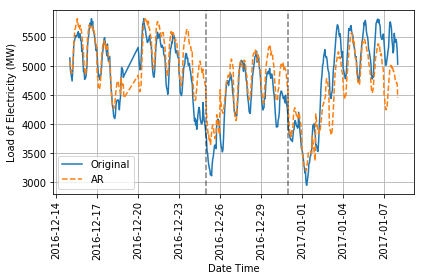

In [17]:
# Declare, fit, predict
model3 = AR(base)
model3.fit()
ypred3 = model3.predict(model3.X)

start_date = dt.datetime(2016,12,15)
end_date = dt.datetime(2017,1,8)
plot_load_prediction(base, ypred3, start_date, end_date, 'AR', 
                     output_path='./outputs/model3_ar.png')


In [18]:
######################################
# TIME SERIES MODELS 4: ARX
######################################

class ARX(object):
    def __init__(self, base, **kwargs):
        self.base = base
        self.model = LinearRegression(**kwargs)
        variables = ['sX.ones', 'sX.lag24_y', 'sX.lag168_y', 
                     's0.monday', 's0.sunday', 's0.saturday',
                     'sX.temp_c_1', 'sX.temp_c_2', 'sX.temp_c_3']
        
        self.X = self.base[variables]
        self.Y = self.base['sX.y']
    
    def fit(self):
        self.model.fit(self.X, self.Y)
    
    def predict(self, X):
        Ypred = pd.DataFrame(self.base['date_time'].copy())
        Ypred['ypred'] = self.model.predict(X)
        return Ypred


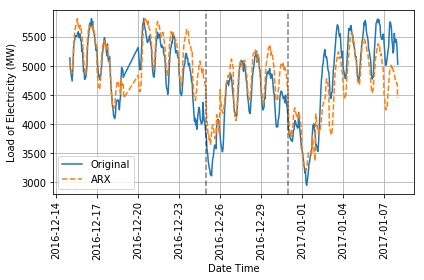

In [19]:
# Declare, fit, predict
model4 = ARX(base)
model4.fit()
ypred4 = model4.predict(model4.X)

start_date = dt.datetime(2016,12,15)
end_date = dt.datetime(2017,1,8)
plot_load_prediction(base, ypred3, start_date, end_date, 'ARX', 
                     output_path='./outputs/model4_arx.png')


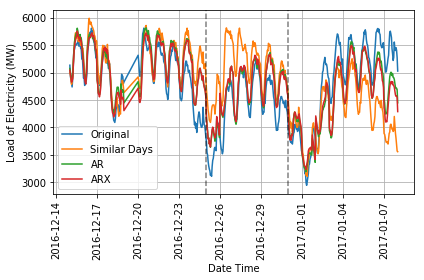

In [20]:
# PLOT DEMAND CHRISTMAS-NEW YEAR
def plot_load_predictions(data, predictions, start_date, end_date, output_path=None):
    assert data.shape[0]==predictions['ar'].shape[0]
    filter_plot = (data['date_time']>=start_date) & (data['date_time']<=end_date)
    data_plot = data[filter_plot]
    
    similar_days_pred = predictions['similar days'][filter_plot]
    ar_pred           = predictions['ar'][filter_plot]
    arx_pred          = predictions['arx'][filter_plot]
    
    plt.plot(data_plot['date_time'], data_plot['s2.NES'], label='Original')
    plt.plot(data_plot['date_time'], similar_days_pred['ypred'], label='Similar Days')
    plt.plot(data_plot['date_time'], ar_pred['ypred'], label='AR')
    plt.plot(data_plot['date_time'], arx_pred['ypred'], label='ARX')
    
    plt.ylabel('Load of Electricity (MW)')
    plt.xlabel('Date Time')
    plt.xticks(rotation=90)
    plt.axvline(x=dt.datetime(2016,12,25), color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=dt.datetime(2016,12,31), color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.grid()
    plt.legend()
    if output_path is not None:
        plt.savefig(output_path, pad_inches=0.1)
    plt.show()

ypreds = {'similar days': ypred1, 'ar': ypred3, 'arx': ypred4}
start_date = dt.datetime(2016,12,15)
end_date = dt.datetime(2017,1,8)
plot_load_predictions(base, ypreds, start_date, end_date, output_path='./outputs/models.png')


In [21]:
######################################
# MODEL EVALUATION
######################################

# print(ypred1.isna().sum())
ypred1 = ypred1.fillna(pd.DataFrame.mean(ypred1['ypred']))
mse_model1 = mean_squared_error(base['sX.y'], ypred1['ypred'])

# print(ypred3.isna().sum())
mse_model3 = mean_squared_error(base['sX.y'], ypred3['ypred'])

# print(ypred4.isna().sum())
mse_model4 = mean_squared_error(base['sX.y'], ypred4['ypred'])

mses = [['Similar Days', np.round_(mse_model1,2)],
        ['Autorregresive', np.round_(mse_model3,2)],
        ['Autorregresive X', np.round_(mse_model4,2)]]
mses_summary = pd.DataFrame(mses, columns=['Models','MSE'])
print(mses_summary)


             Models        MSE
0      Similar Days  220493.21
1    Autorregresive   96361.41
2  Autorregresive X   93352.11
